In [1]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pymysql
import config
%matplotlib inline
import seaborn as sns

In [2]:
conn = pymysql.connect(config.host, user=config.username,port=config.port,
                           passwd=config.password)

#gather all historical data to build model
RideWaits = pd.read_sql_query("call DisneyDB.RideWaitQuery('2,7,8,9')", conn)

# Disney Wait Times

This Jupyter notebook will serve as some exploratory analysis amongst wait times to gain any introductory information as to the relationship between wait times and other categories. This will also prove as a place to show the transformations that the data frame will undergo to gain some of the other wanted features that I believe to be useful in this exercise. 

In [ ]:
RideWaits

In [3]:
RideWaits["RideId"] = pd.Categorical(RideWaits["RideId"])
#RideWaits["Status"] = pd.Categorical(RideWaits["Status"])
RideWaits["ParkId"] = pd.Categorical(RideWaits["ParkId"])
RideWaits["Tier"] = pd.Categorical(RideWaits["Tier"])
RideWaits["ParkName"] = pd.Categorical(RideWaits["ParkName"])
RideWaits["IntellectualProp"] = pd.Categorical(RideWaits["IntellectualProp"])
RideWaits["Date"] = pd.to_datetime(RideWaits["Date"], infer_datetime_format = True)
RideWaits["OpeningDate"] = pd.to_datetime(RideWaits["OpeningDate"], infer_datetime_format = True)
RideWaits["Time"] = pd.to_datetime(RideWaits["Time"], format = '%H:%M').dt.time
RideWaits["ParkOpen"] = pd.to_datetime(RideWaits["ParkOpen"], format = '%I:%M %p').dt.strftime('%H:%M')
RideWaits["ParkOpen"] = pd.to_datetime(RideWaits["ParkOpen"], format = '%H:%M').dt.time
RideWaits["ParkClose"] = pd.to_datetime(RideWaits["ParkClose"], format = '%I:%M %p').dt.strftime('%H:%M')
RideWaits["ParkClose"] = pd.to_datetime(RideWaits["ParkClose"], format = '%H:%M').dt.time
RideWaits["DayOfWeek"] = [datetime.weekday(x) for x in RideWaits["Date"]]
RideWaits["EMHOpen"] = pd.to_datetime(RideWaits["EMHOpen"], format = '%I:%M %p', errors = 'coerce').dt.strftime('%H:%M')
RideWaits["EMHClose"] = pd.to_datetime(RideWaits["EMHClose"], format = '%I:%M %p', errors = 'coerce').dt.strftime('%H:%M')
RideWaits["EMHOpen"] = pd.to_datetime(RideWaits["EMHOpen"], format = '%H:%M', errors = 'coerce').dt.time
RideWaits["EMHClose"] = pd.to_datetime(RideWaits["EMHClose"], format = '%H:%M', errors = 'coerce').dt.time
RideWaits["Weekend"] = [0 if x == 0 or x == 1 or x ==2 or x==3 or x==4 else 1 for x in RideWaits["DayOfWeek"]]
RideWaits["Weekend"].value_counts()
RideWaits["CharacterExperience"] = [1 if ("Meet" in x) or ("Encounter" in x) or ("Visa" in x) else 0 for x in RideWaits["Name"]]

In [4]:
RideWaits["Date"].value_counts()

2018-09-19    6872
2018-10-04    5312
2018-10-11    3967
2018-10-10    3434
2018-09-29    3433
2018-10-13    3276
2018-10-03    3263
2018-09-22    3237
2018-09-26    3217
2018-10-09    3208
2018-10-06    3202
2018-09-28    3191
2018-09-20    3186
2018-10-12    3154
2018-09-25    3151
2018-10-05    3128
2018-10-02    3111
2018-09-30    3084
2018-09-23    3062
2018-10-01    3041
2018-10-14    2993
2018-10-08    2952
2018-09-27    2867
2018-10-07    2829
2018-09-24    2807
2018-09-21    1435
2018-10-15      21
Name: Date, dtype: int64

In [ ]:
RideWaits

The transformations above get the data ready for analysis, however there may exist some times outside of our viable windows. This next loop should remove all those times, as well as let us know if a time is in Extra Magic hours or not. 

In [5]:
validTime = []
inEMH = []
emhDay = []
timeSinceStart = []
timeSinceMidDay = []
magicHourType = []
timeSinceOpenMinutes = []

for index, row in RideWaits.iterrows():
    #print(row)
    tempTime = datetime.now()
    cTime = row["Time"]
    pOpen = row["ParkOpen"]
    pClose = row["ParkClose"]
    currentParkTime = tempTime.replace(hour = cTime.hour, minute = cTime.minute, second = 0, microsecond = 0)
    parkOpen = tempTime.replace(hour = pOpen.hour, minute = pOpen.minute, second = 0, microsecond = 0)
    parkClose = tempTime.replace(hour = pClose.hour, minute = pClose.minute, second = 0, microsecond = 0)
    if parkClose < parkOpen:
        parkClose = parkClose.replace(day = parkClose.day + 1)
    if (pd.notnull(row["EMHOpen"])) & (pd.notnull(row["EMHClose"])):
        eOpen = row["EMHOpen"]
        #print(eOpen)
        eClose = row["EMHClose"]
        #print(eClose)
        emhOpen = tempTime.replace(hour = eOpen.hour, minute = eOpen.minute, second = 0, microsecond = 0)
        emhClose = tempTime.replace(hour = eClose.hour, minute = eClose.minute, second = 0, microsecond = 0)
        if emhClose < emhOpen:
            emhClose = emhClose.replace(day = emhClose.day + 1)
        emh = "ok"
        emhDay.append(1)
        if emhClose.hour == parkOpen.hour:
            magicHourType.append("Morning")
        else:
            magicHourType.append("Night")
    else:
        emh = "none"
        emhDay.append(0)
        magicHourType.append("None")
        
    #print(emh)
    if (currentParkTime < parkClose) & (currentParkTime > parkOpen):
        #print("Current Time is: " + str(currentParkTime) + " and ParkHours are "+ str(parkOpen) +" to " + str(parkClose) + " " +str(validtime))
        tSinceOpen = currentParkTime.hour - parkOpen.hour
        tSinceOpenMinutes = currentParkTime - parkOpen
        tSinceMidDay = abs(currentParkTime.hour - 14)
        if currentParkTime.hour < parkOpen.hour:
            tSinceOpen = currentParkTime.hour + 24 - parkOpen.hour
            tSinceOpenMinutes = currentParkTime.replace(day = currentParkTime.day + 1) - parkOpen
            tSinceMidDay = abs(currentParkTime.hour - 14 + 24)
        validTime.append(1)
        inEMH.append(0)
    else:
        if (emh == "ok"):
            if (currentParkTime < emhClose) & (currentParkTime > emhOpen):
                validTime.append(1)
                inEMH.append(1)
                if (emhClose.hour == parkOpen.hour):
                    tSinceOpen = currentParkTime.hour - emhOpen.hour
                    tSinceOpenMinutes = currentParkTime - emhOpen
                    tSinceMidDay = abs(currentParkTime.hour - 14)

                else:
                    if currentParkTime.hour < parkOpen.hour:
                        tSinceOpen = currentParkTime.hour + 24 - parkOpen.hour
                        tSinceOpenMinutes = currentParkTime.replace(day = currentParkTime.day + 1) - parkOpen
                        tSinceMidDay = abs(currentParkTime.hour - 14 + 24)
                    else:
                        tSinceOpen = currentParkTime.hour - parkOpen.hour
                        tSinceOpenMinutes = currentParkTime - parkOpen
                        tSinceMidDay = abs(currentParkTime.hour - 14)
            else:
                validTime.append(0)
                inEMH.append(0)
        else:
            validTime.append(0)
            inEMH.append(0)
    timeSinceStart.append(tSinceOpen)
    timeSinceMidDay.append(tSinceMidDay)
    timeSinceOpenMinutes.append(tSinceOpenMinutes)


RideWaits["inEMH"] = inEMH
RideWaits["validTime"] = validTime
RideWaits["EMHDay"] = emhDay
RideWaits["TimeSinceOpen"] = timeSinceStart
RideWaits["TimeSinceMidday"] = timeSinceMidDay
RideWaits["MagicHourType"] = magicHourType
RideWaits["MinutesSinceOpen"] = [x.total_seconds()/60 for x in timeSinceOpenMinutes]
#RideWaits["SimpleStatus"] = pd.Categorical(RideWaits["SimpleStatus"])
RideWaits = RideWaits[RideWaits["validTime"] == 1]

RideWaits["Month"] = RideWaits["Date"].dt.month
RideWaits["TimeSinceRideOpen"] = (RideWaits["Date"] - RideWaits["OpeningDate"]).dt.days

The features above are generally transformations of the data with the exception of Day of the Week where that is extracted from the date object.

## Relationships between Different Categories and Wait Time

In this section we will explore the relationship directly to different group categories as shown below. 

* Day of Week
* Ride Name
* Time of Day
* Park
* Ride/Time of Day
* Park/Time of Day
* Tier/Time of Day
* If it's an extra magic hour day
* In Extra Magic hours or not

In [6]:
RideWaits["Wait"].describe()

count    75039.000000
mean        29.422127
std         24.161024
min          0.000000
25%         10.000000
50%         20.000000
75%         40.000000
max        305.000000
Name: Wait, dtype: float64

In [7]:
RideWaits["DayOfWeek"].value_counts()

2    15618
3    12813
5    12601
6    10042
4     8491
0     7931
1     7543
Name: DayOfWeek, dtype: int64

In [8]:
RideWaits.groupby('DayOfWeek')['Wait'].mean()

DayOfWeek
0    31.559072
1    25.976535
2    27.463055
3    26.664247
4    29.370628
5    33.537814
6    31.767377
Name: Wait, dtype: float64

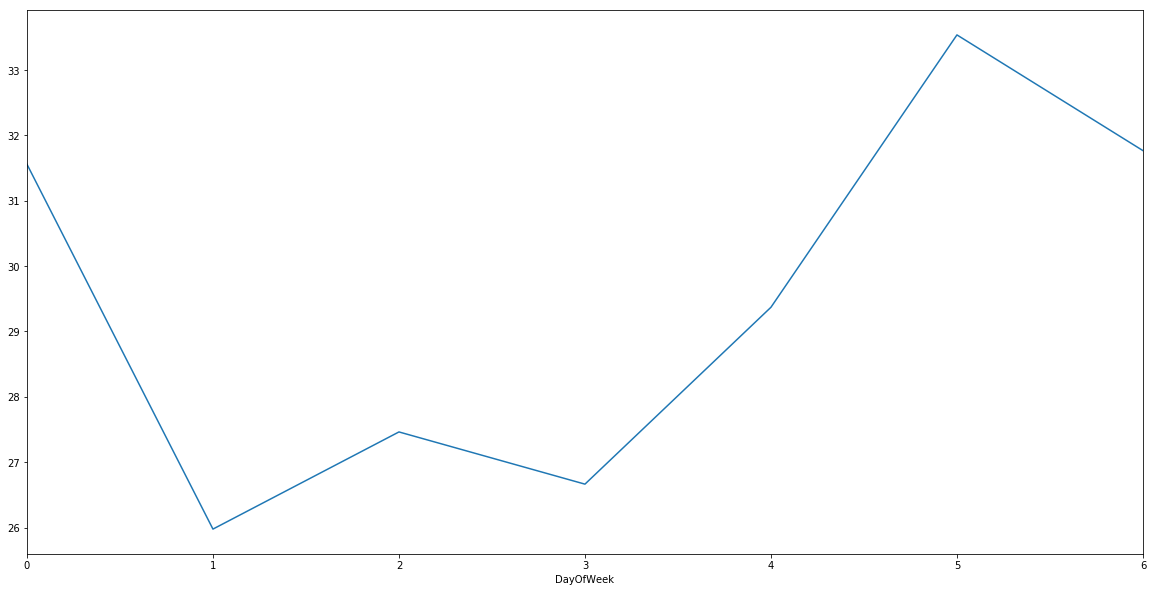

In [9]:
fig,ax= plt.subplots(figsize = (20,10))
RideWaits.groupby('DayOfWeek')['Wait'].mean().plot(ax = ax)
plt.show()

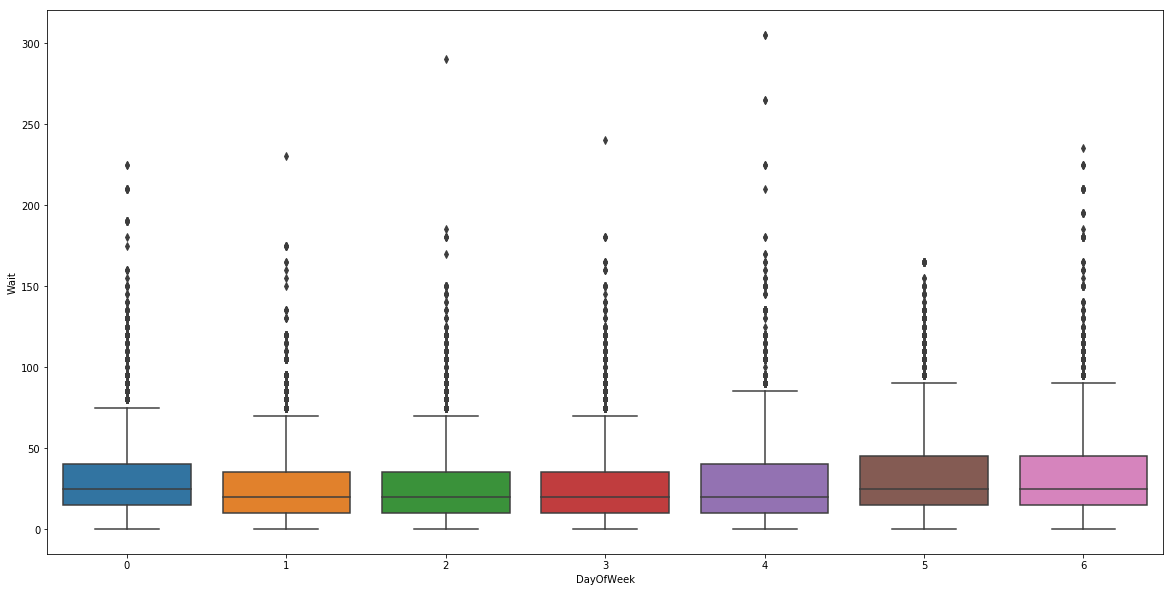

In [10]:
plt.subplots(figsize = (20,10))
ax = sns.boxplot(x = "DayOfWeek", y = "Wait", data = RideWaits)
plt.show()

In [11]:
RideWaits.groupby('Name')['Wait'].mean()

Name
A Pirates Adventure ~ Treasures of the Seven Seas                           0.000000
Alien Swirling Saucers                                                     35.394402
Astro Orbiter                                                              21.626556
Avatar Flight of Passage                                                  104.592094
BB-8 Astromech on Duty                                                     17.545455
Big Thunder Mountain Railroad                                              30.398936
Buzz Lightyears Space Ranger Spin                                          30.601926
Celebrity Spotlight                                                        15.105042
DINOSAUR                                                                   24.024390
Dumbo the Flying Elephant                                                  19.282753
Enchanted Tales with Belle                                                 28.556789
Expedition Everest - Legend of the Forbidden Mountain       

This extremely large data frame may not be particularly useful by itself. We'll dive into these figures in another cell later on. 

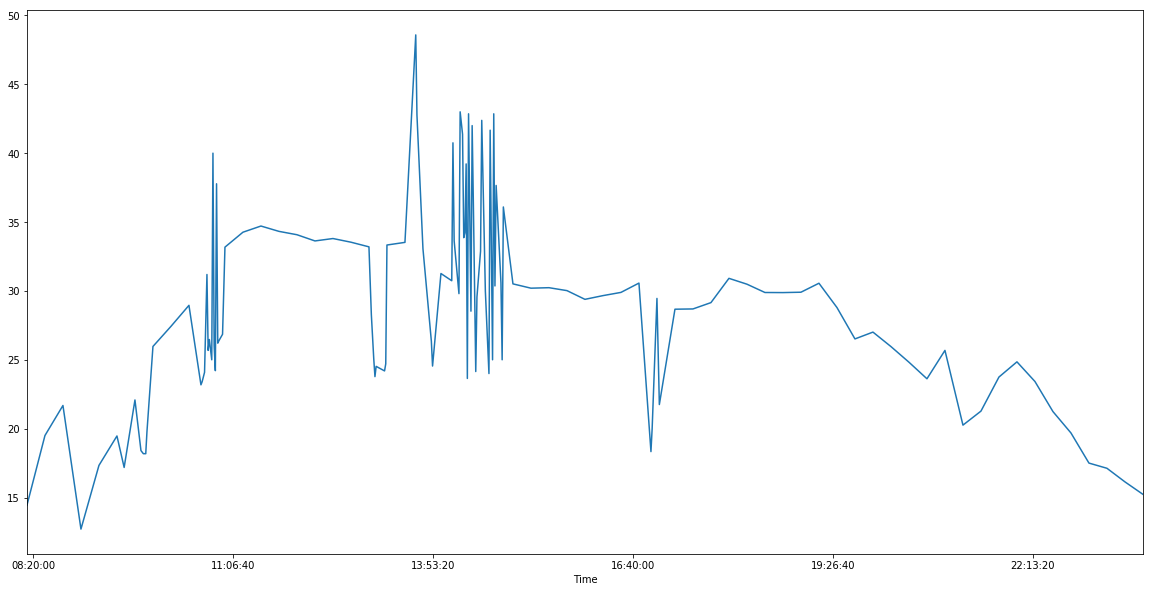

In [12]:
fig,ax= plt.subplots(figsize = (20,10))
RideWaits.groupby('Time')['Wait'].mean().plot(ax = ax)
plt.show()

We see that the wait time follows a general curve through the day, signaling that time of day is a huge factor in the wait times at the park. The wait time increases to a point, roughly 14:00, then decreases from that point to the end of the day. It mirrors a y = -|x| situation. We can attempt to recreate this by creating a value that emulates the time since midday, signaling midday as 14:00.

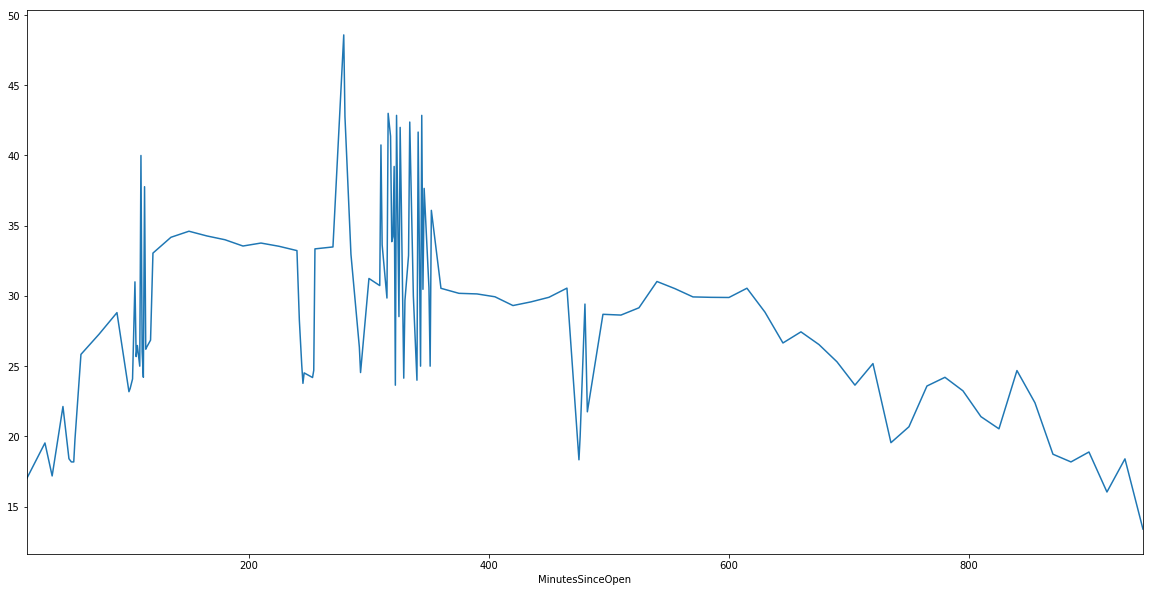

In [13]:
fig,ax= plt.subplots(figsize = (20,10))
RideWaits.groupby('MinutesSinceOpen')['Wait'].mean().plot(ax = ax)
plt.show()

In [14]:
RideWaits.corr()["Wait"]["TimeSinceMidday"]

-0.10210993920545801

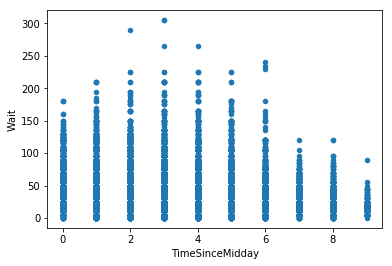

In [15]:
RideWaits.plot(x = "TimeSinceMidday", y = "Wait", kind = "scatter")

It's generally hard to see if there is any sort of trend with every single point. If we group by the number of hours since midday perhaps we can see a general trend. 

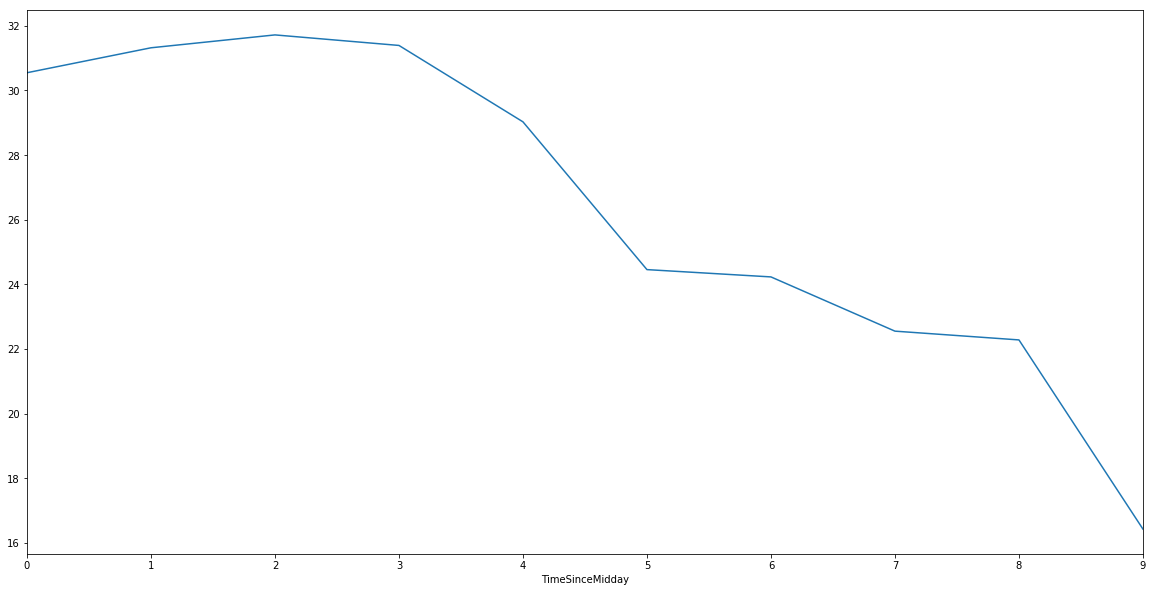

In [16]:
fig,ax= plt.subplots(figsize = (20,10))
RideWaits.groupby('TimeSinceMidday')['Wait'].mean().plot(ax = ax)
plt.show()

In [17]:
RideWaits.groupby('TimeSinceMidday')['Wait'].describe()

,count,mean,std,min,25%,50%,75%,max
TimeSinceMidday,,,,,,,,
0,7723.0,30.548362,23.833584,0.0,15.0,25.0,40.0,180.0
1,13473.0,31.320419,23.876647,0.0,15.0,25.0,40.0,210.0
2,12899.0,31.719126,24.406910,0.0,15.0,25.0,45.0,290.0
3,13170.0,31.393318,24.748845,0.0,15.0,25.0,40.0,305.0
4,12163.0,29.029022,24.685129,0.0,10.0,20.0,40.0,265.0
5,9627.0,24.456113,23.495238,0.0,10.0,15.0,35.0,225.0
6,3332.0,24.230192,23.380094,0.0,10.0,15.0,35.0,240.0
7,1452.0,22.551653,17.502016,0.0,10.0,15.0,30.0,120.0
8,956.0,22.280335,17.735074,0.0,10.0,15.0,30.0,120.0


As suspected, the wait time decreases as the time moves away from the midpoint of the day. 

In [18]:
RideWaits.groupby('ParkName')['Wait'].describe()


,count,mean,std,min,25%,50%,75%,max
ParkName,,,,,,,,
Disneys Animal Kingdom Theme Park,11092.0,36.160746,35.048790,5.0,10.0,25.0,50.0,305.0
Disneys Hollywood Studios,13966.0,31.630674,24.682045,5.0,15.0,25.0,45.0,190.0
EpCot,15418.0,25.498443,19.513102,0.0,10.0,20.0,35.0,290.0
Magic Kingdom Park,34563.0,28.117438,20.786651,0.0,10.0,25.0,40.0,185.0


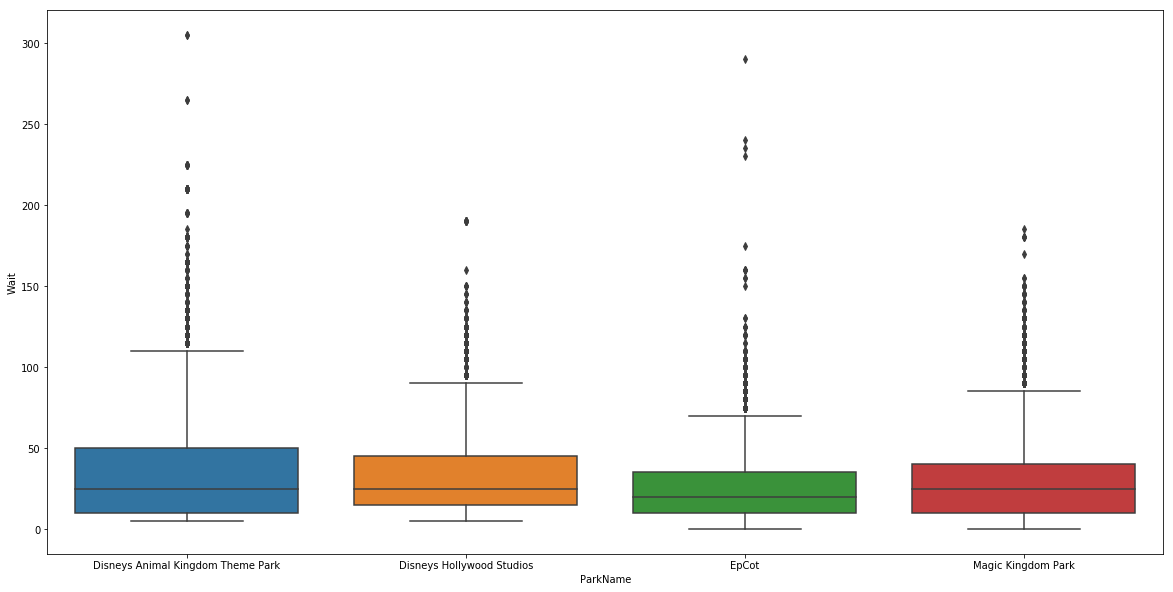

In [19]:
plt.subplots(figsize = (20,10))
ax = sns.boxplot(x = "ParkName", y = "Wait", data = RideWaits)
plt.show()

We see quickly from this box and whisker plot as well as with the described data frame above that Epcot and Hollywood studios have nearly identical wait times, Animal Kingdom has the largest Interquartile range and the highest mean. This may be due to the addition of two new rides that have been recently experiencing some dramatically high wait times. This leads me to believe that 'newness' of ride contributes to wait time. This leads to that being an engineered feature later on.

In [20]:
from scipy import stats
t,p = stats.ttest_ind(RideWaits["Wait"], RideWaits[RideWaits["ParkName"]=="Disneys Animal Kingdom Theme Park"]["Wait"])
print(t, p)

-25.653802922749378 1.3445645434200947e-144


This means that a ride in  Animal kingdom will have a greater mean wait time than an average ride in Walt Disney World. This is most likely due to the addition of Pandora.

In [21]:
rideSummaryStats = RideWaits.groupby('Name')['Wait'].describe()
rideSummaryStats.head(15)

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
A Pirates Adventure ~ Treasures of the Seven Seas,13.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Alien Swirling Saucers,1179.0,35.394402,11.036735,5.0,30.0,35.0,40.0,80.0
Astro Orbiter,1205.0,21.626556,8.057206,5.0,15.0,20.0,25.0,55.0
Avatar Flight of Passage,1189.0,104.592094,38.962526,40.0,75.0,95.0,125.0,305.0
BB-8 Astromech on Duty,1155.0,17.545455,7.166403,5.0,10.0,15.0,20.0,45.0
Big Thunder Mountain Railroad,1128.0,30.398936,19.037871,5.0,15.0,30.0,40.0,120.0
Buzz Lightyears Space Ranger Spin,1246.0,30.601926,15.694077,5.0,20.0,30.0,40.0,100.0
Celebrity Spotlight,1190.0,15.105042,7.351666,5.0,10.0,15.0,20.0,50.0
DINOSAUR,1025.0,24.024390,14.968208,5.0,10.0,20.0,35.0,90.0


In [22]:
RideWaits.groupby('Tier')['Wait'].describe()


,count,mean,std,min,25%,50%,75%,max
Tier,,,,,,,,
diversion,6103.0,22.595445,12.119584,0.0,15.0,20.0,30.0,100.0
headliner,10310.0,36.483996,26.547451,5.0,15.0,30.0,50.0,190.0
major_attraction,16971.0,29.077426,24.942555,0.0,10.0,20.0,40.0,185.0
minor_attraction,29712.0,23.596190,16.709365,0.0,10.0,20.0,30.0,120.0
super_headliner,10755.0,44.953882,33.441161,5.0,20.0,35.0,60.0,305.0


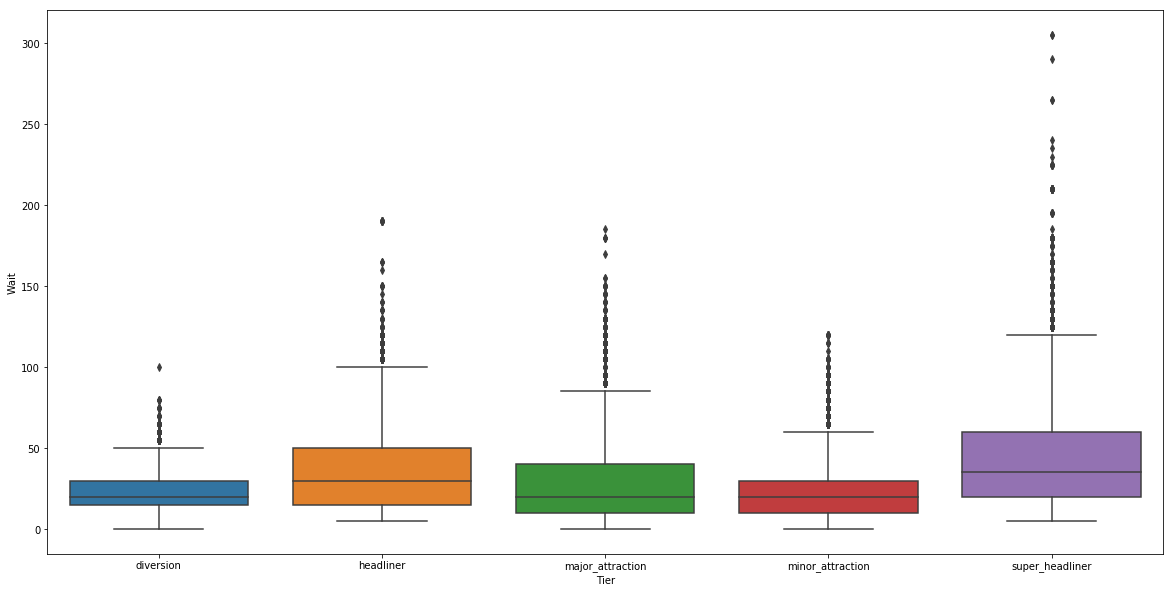

In [23]:
plt.subplots(figsize = (20,10))
ax = sns.boxplot(x = "Tier", y = "Wait", data = RideWaits)
plt.show()

This follows mostly what our preconceived notions would be:
Super headliner attractions dominate the wait times followed by headlines. This leads to wanting inspect the data some more to understand what differentiates between headliner and major attraction or major attraction and minor attraction as those two have nearly identical wait times. 

In [24]:
RideWaits.groupby('EMHDay')['Wait'].describe()

,count,mean,std,min,25%,50%,75%,max
EMHDay,,,,,,,,
0,53689.0,29.278362,23.861913,0.0,10.0,20.0,40.0,305.0
1,21350.0,29.783653,24.894224,0.0,10.0,20.0,40.0,240.0


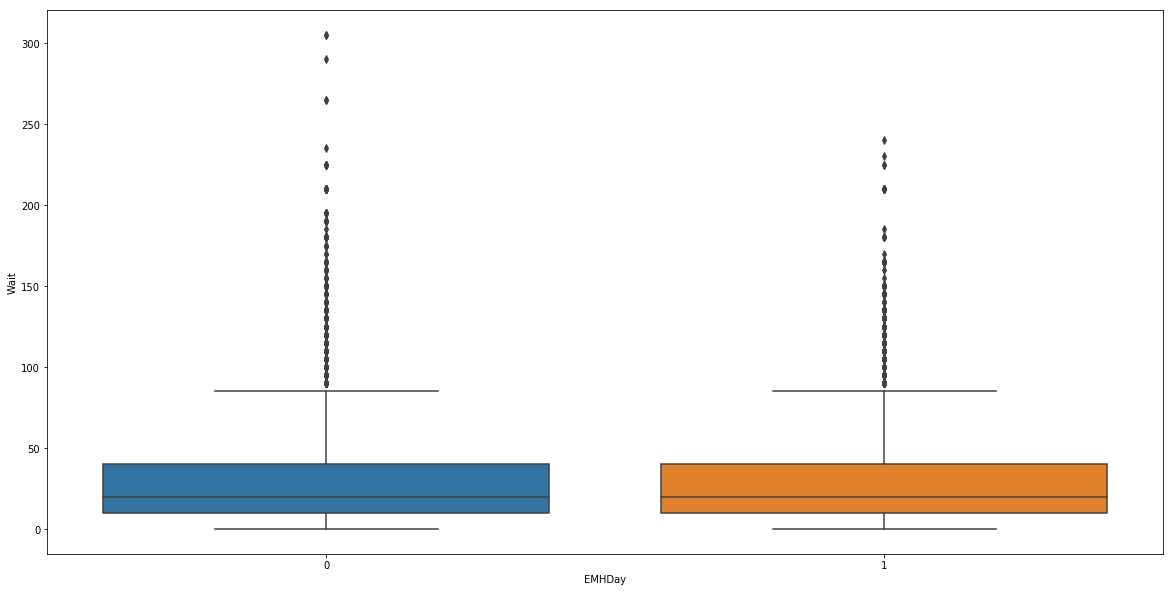

In [25]:
plt.subplots(figsize = (20,10))
ax = sns.boxplot(x = "EMHDay", y = "Wait", data = RideWaits)
plt.show()

In [26]:
t, p = stats.ttest_ind(RideWaits[RideWaits["EMHDay"] == 0]["Wait"], RideWaits[RideWaits["EMHDay"]==1]["Wait"])
print(t)
print(p)

-2.5848820411774356
0.009743100828114158


The working assumption in most Disney Park planning sites is that if you don't need to go to a park when it has extra magic hours, don't because it will be more packed. We see that there is statistical significance in the difference and can say with confidence that Extra Magic hours increase the wait time.

In [27]:
RideWaits.groupby('inEMH')['Wait'].describe()

,count,mean,std,min,25%,50%,75%,max
inEMH,,,,,,,,
0,73641.0,29.645863,24.181680,0.0,10.0,20.0,40.0,305.0
1,1398.0,17.636624,19.745869,0.0,5.0,10.0,20.0,180.0


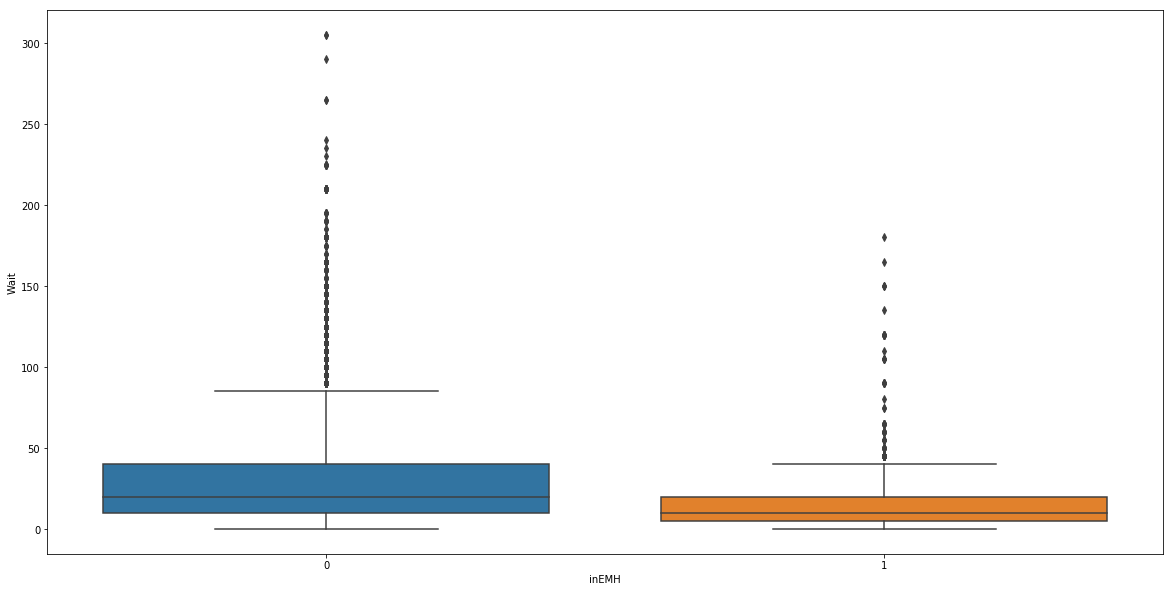

In [28]:
plt.subplots(figsize = (20,10))
ax = sns.boxplot(x = "inEMH", y = "Wait", data = RideWaits)
plt.show()

In [29]:
t, p = stats.ttest_ind(RideWaits[RideWaits["inEMH"] == 0]["Wait"], RideWaits[RideWaits["inEMH"]==1]["Wait"])
print(t)
print(p)

18.452290130134408
7.362572571946482e-76


Again this goes with typical thought. If you ride attractions during extra magic hours, you will be subject to lower wait times than those outsie of extra magic hours. We see a difference of wait time by 14 minutes. We see that our p value is significantly small, much below our threshold. We can say with statistical significance that the mean wait time while in extra magic hours is lower than outside of extra magic hours.

In [30]:
RideWaits.groupby('MagicHourType')['Wait'].describe()

,count,mean,std,min,25%,50%,75%,max
MagicHourType,,,,,,,,
Morning,11411.0,29.943738,26.629256,0.0,10.0,20.0,40.0,240.0
Night,9939.0,29.599859,22.739518,0.0,15.0,25.0,40.0,230.0
None,53689.0,29.278362,23.861913,0.0,10.0,20.0,40.0,305.0


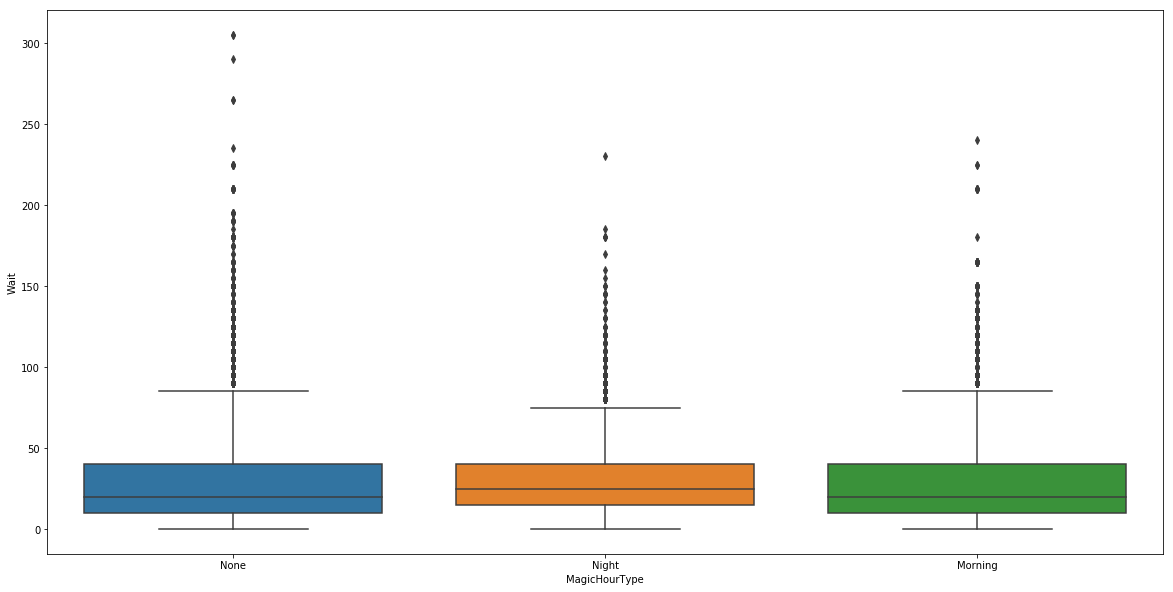

In [31]:
plt.subplots(figsize = (20,10))
ax = sns.boxplot(x = "MagicHourType", y = "Wait", data = RideWaits)
plt.show()

## Descriptive Plots

Below we have some plots that show all the rides grouped by park. First the wait average wait times by ride and time slot are shown, followed by the average wait times by tier and time slot.

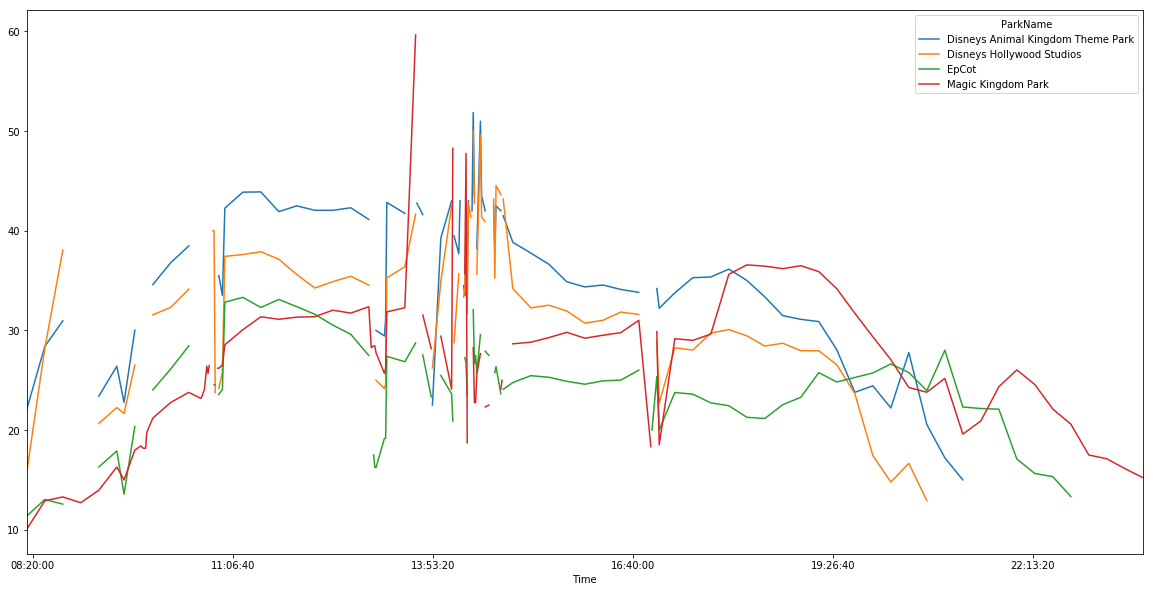

In [32]:
fig,ax = plt.subplots(figsize = (20,10))
RideWaits.groupby(['Time','ParkName'])['Wait'].mean().unstack().plot(ax = ax)
plt.show()

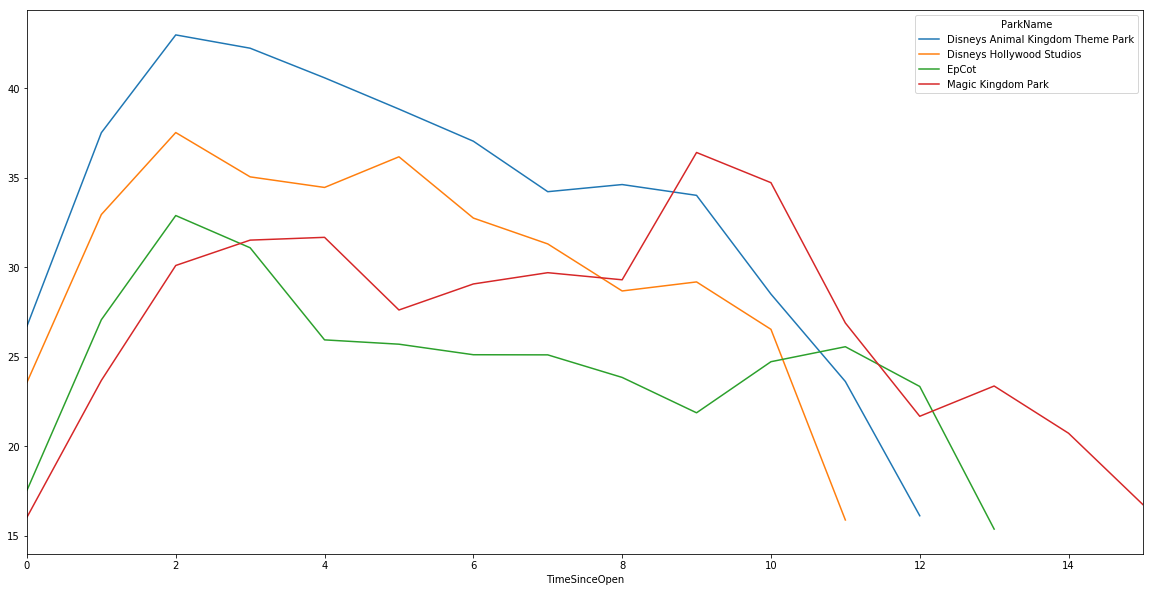

In [33]:
fig,ax = plt.subplots(figsize = (20,10))
RideWaits.groupby(['TimeSinceOpen','ParkName'])['Wait'].mean().unstack().plot(ax = ax)
plt.show()

By normalizing across the parks for 'TimeSinceOpen' we get ride of some of the noise potentially associated with minor fluctuations per 15 minutes as well as different opening times across the parks. We also see a single spike in Magic Kingdom times before park open, that is clearly associated with a high popularity ride being open during Extra Magic Hours. 

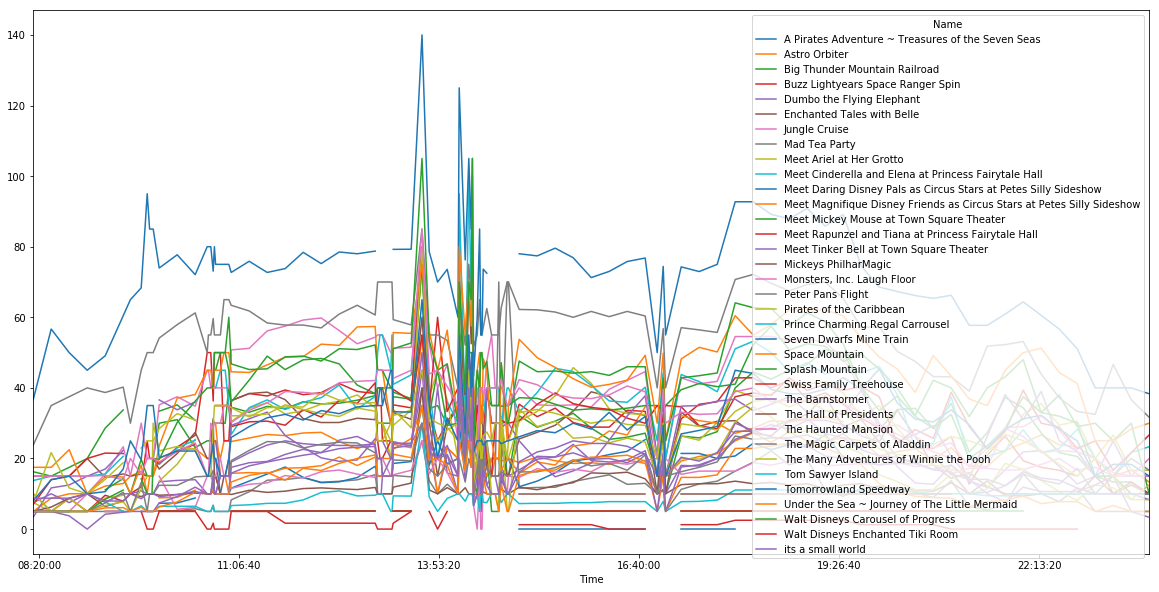

In [34]:
fig,ax = plt.subplots(figsize = (20,10))
RideWaits[RideWaits["ParkName"]=="Magic Kingdom Park"].groupby(['Time','Name'])['Wait'].mean().unstack().plot(ax = ax)
plt.show()

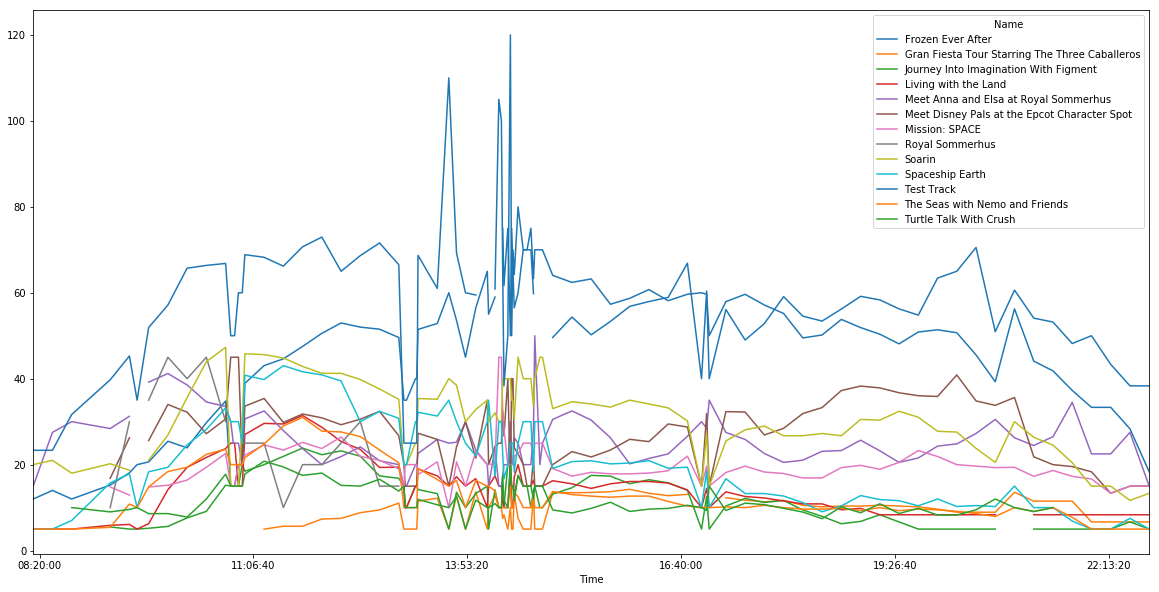

In [35]:
fig,ax = plt.subplots(figsize = (20,10))
RideWaits[RideWaits["ParkName"]=="EpCot"].groupby(['Time','Name'])['Wait'].mean().unstack().plot(ax = ax)
plt.show()

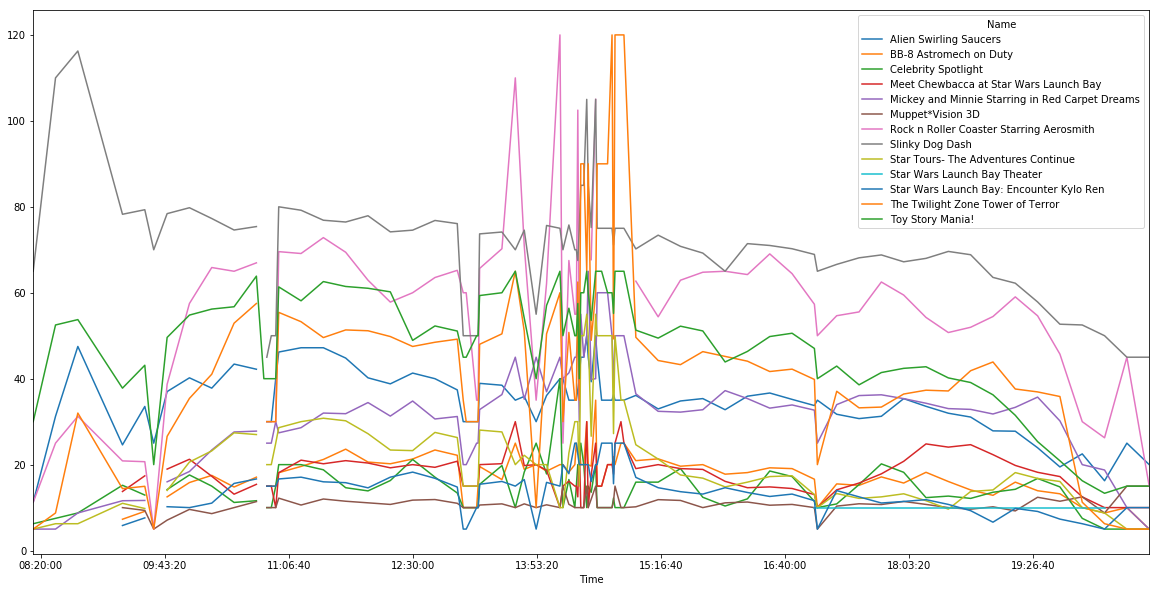

In [36]:
fig,ax = plt.subplots(figsize = (20,10))
RideWaits[RideWaits["ParkName"]=="Disneys Hollywood Studios"].groupby(['Time','Name'])['Wait'].mean().unstack().plot(ax = ax)
plt.show()

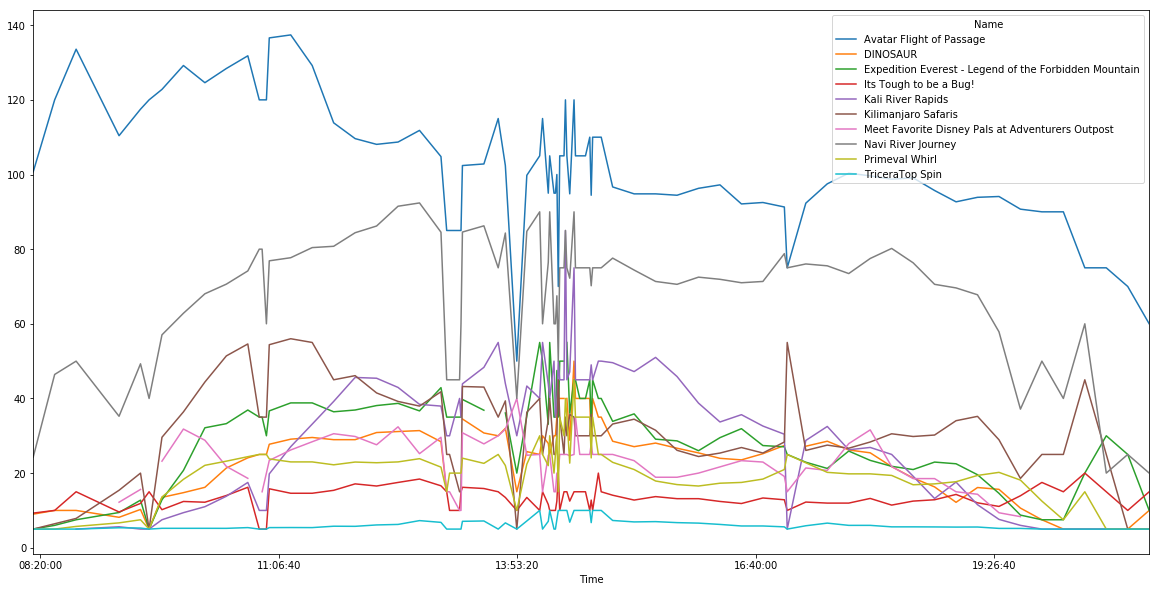

In [37]:
fig,ax = plt.subplots(figsize = (20,10))
RideWaits[RideWaits["ParkName"]=="Disneys Animal Kingdom Theme Park"].groupby(['Time','Name'])['Wait'].mean().unstack().plot(ax = ax)
plt.show()

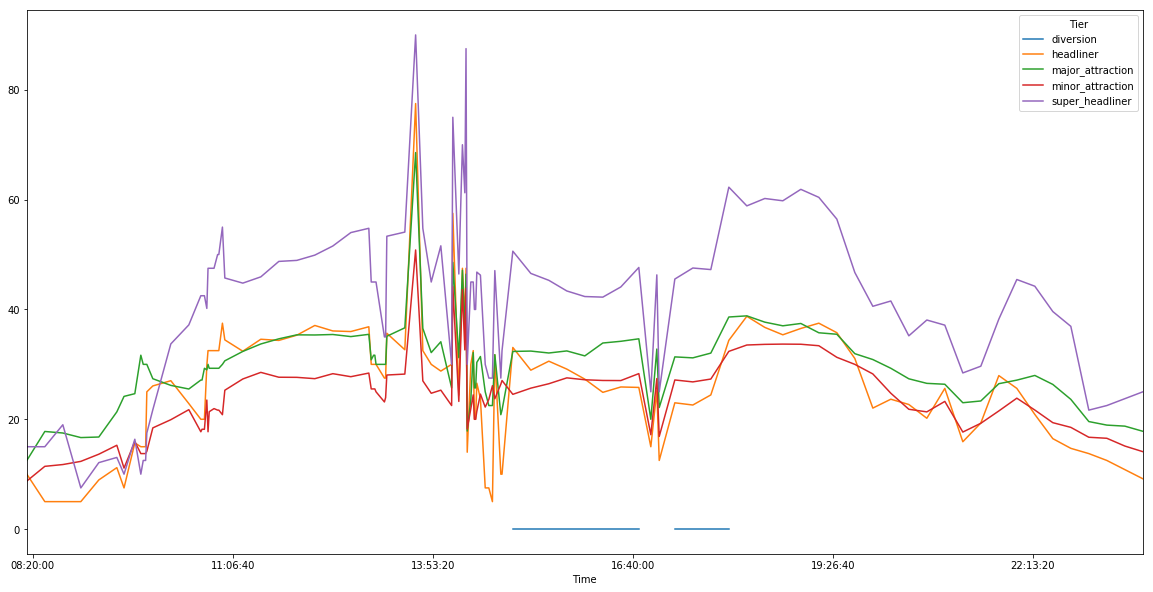

In [38]:
fig,ax = plt.subplots(figsize = (20,10))
RideWaits[RideWaits["ParkName"]=="Magic Kingdom Park"].groupby(['Time','Tier'])['Wait'].mean().unstack().plot(ax = ax)
plt.show()


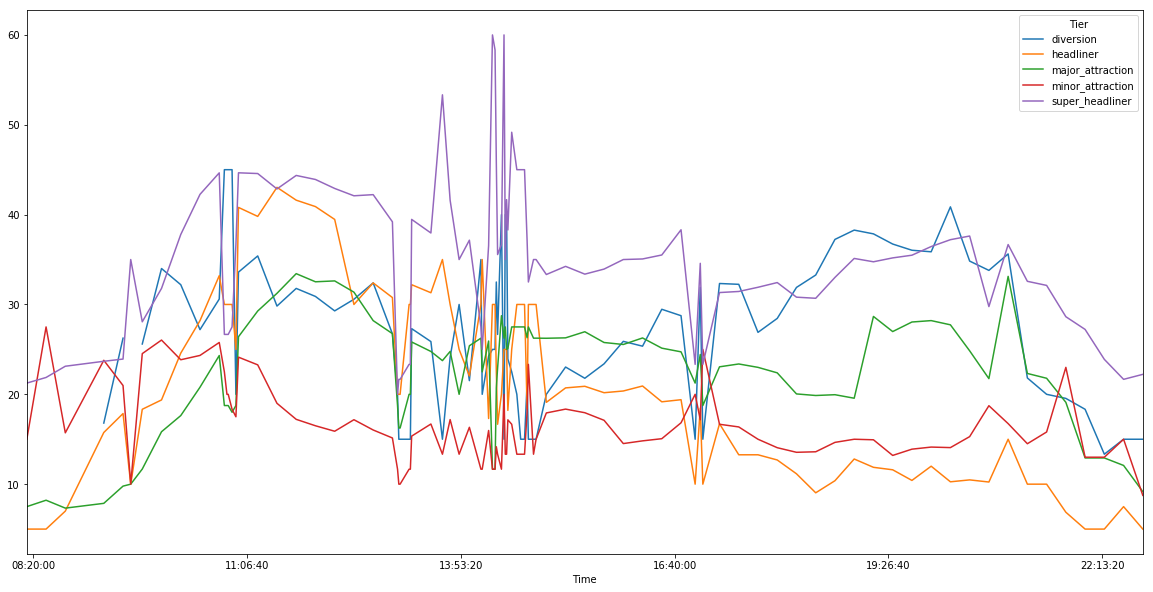

In [39]:
fig,ax = plt.subplots(figsize = (20,10))
RideWaits[RideWaits["ParkName"]=="EpCot"].groupby(['Time','Tier'])['Wait'].mean().unstack().plot(ax = ax)
plt.show()

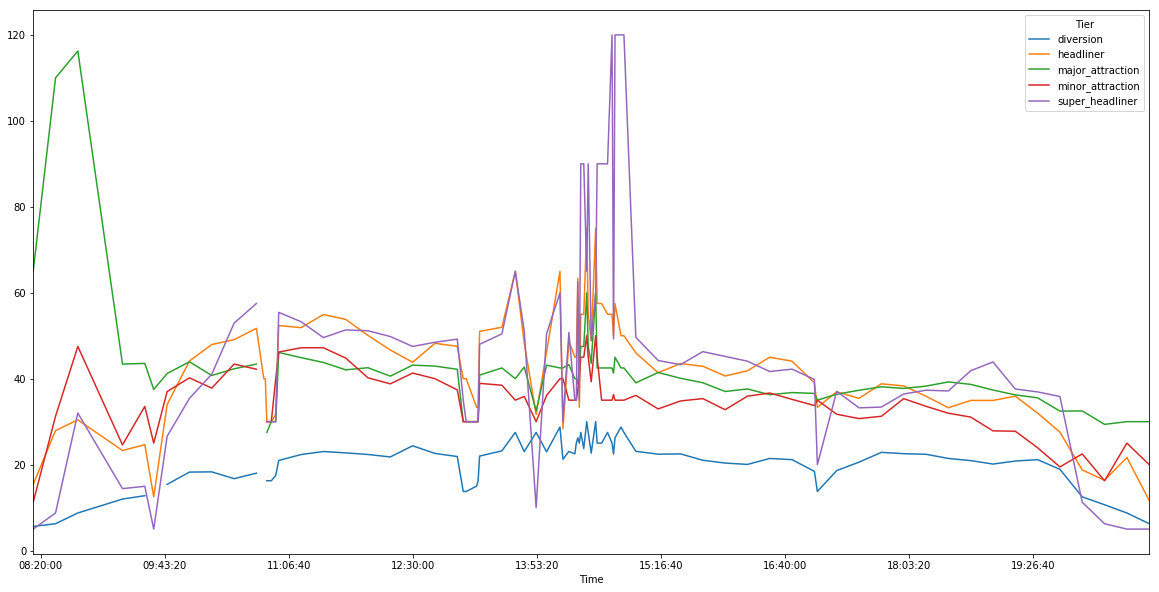

In [40]:
fig,ax = plt.subplots(figsize = (20,10))
RideWaits[RideWaits["ParkName"]=="Disneys Hollywood Studios"].groupby(['Time','Tier'])['Wait'].mean().unstack().plot(ax = ax)
plt.show()

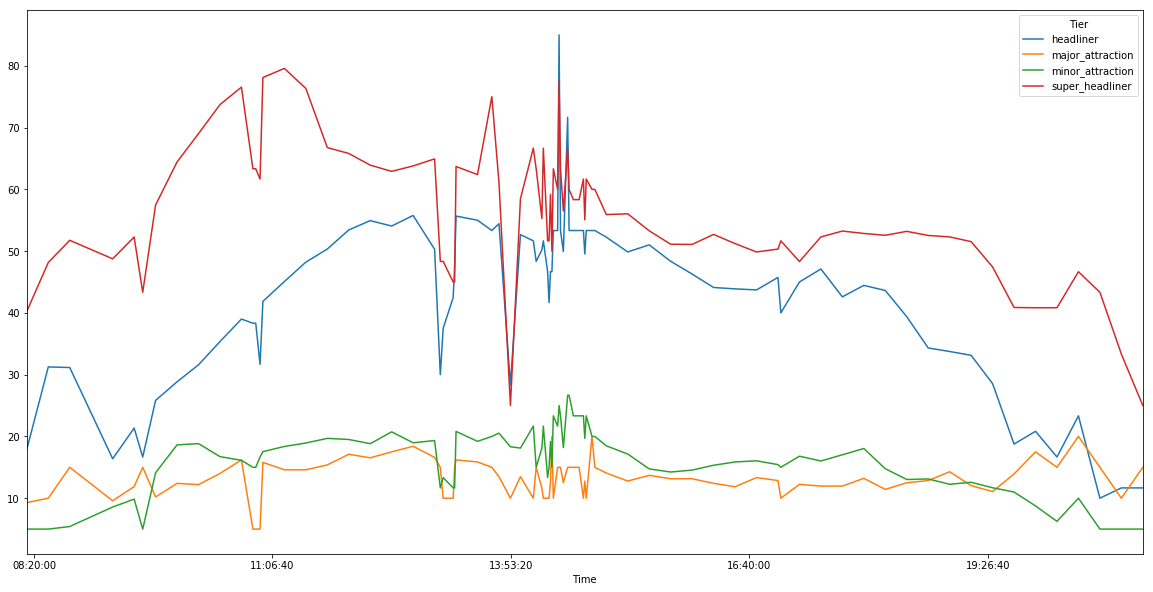

In [41]:
fig,ax = plt.subplots(figsize = (20,10))
RideWaits[RideWaits["ParkName"]=="Disneys Animal Kingdom Theme Park"].groupby(['Time','Tier'])['Wait'].mean().unstack().plot(ax = ax)
plt.show()

# Investigating High Wait Time Attractions

In [42]:
rideSummaryStats = rideSummaryStats.sort_values(by = ['mean'], ascending = False)
topWaits = rideSummaryStats.iloc[:10]
topWaits

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
Avatar Flight of Passage,1189.0,104.592094,38.962526,40.0,75.0,95.0,125.0,305.0
Seven Dwarfs Mine Train,1137.0,73.671944,26.277143,10.0,55.0,70.0,85.0,185.0
Navi River Journey,1131.0,71.949602,23.234589,5.0,60.0,70.0,85.0,165.0
Slinky Dog Dash,1107.0,71.648600,18.683291,30.0,60.0,70.0,85.0,135.0
Test Track,1192.0,58.989094,25.132844,20.0,40.0,55.0,70.0,290.0
Rock n Roller Coaster Starring Aerosmith,1123.0,58.713268,28.893986,5.0,40.0,50.0,75.0,145.0
Peter Pans Flight,1228.0,56.917752,17.334823,10.0,45.0,55.0,65.0,120.0
Frozen Ever After,1349.0,48.632320,17.755169,10.0,35.0,50.0,60.0,125.0
Toy Story Mania!,1159.0,48.433995,22.789733,10.0,35.0,45.0,60.0,190.0


We can investigate these high wait time rides and see what commonalities they share. 

In [43]:
topRides = RideWaits[RideWaits["Name"].isin(topWaits.index)]
information = topRides.groupby(['Name','ParkName','OpeningDate']).size().reset_index()
information

,Name,ParkName,OpeningDate,0
0,Avatar Flight of Passage,Disneys Animal Kingdom Theme Park,2017-05-27,1189
1,Frozen Ever After,EpCot,2016-06-21,1349
2,Navi River Journey,Disneys Animal Kingdom Theme Park,2017-05-27,1131
3,Peter Pans Flight,Magic Kingdom Park,1971-10-01,1228
4,Rock n Roller Coaster Starring Aerosmith,Disneys Hollywood Studios,1999-07-29,1123
5,Seven Dwarfs Mine Train,Magic Kingdom Park,2014-05-28,1137
6,Slinky Dog Dash,Disneys Hollywood Studios,2018-06-30,1107
7,Space Mountain,Magic Kingdom Park,1975-01-15,1146
8,Test Track,EpCot,1999-03-16,1192
9,Toy Story Mania!,Disneys Hollywood Studios,2008-05-31,1159


In [44]:
information["ParkName"].value_counts()

Magic Kingdom Park                   3
Disneys Hollywood Studios            3
EpCot                                2
Disneys Animal Kingdom Theme Park    2
Name: ParkName, dtype: int64

We see that the majority of our rides with long waits, 6 of the 10 are either in Magic Kingdom or Animal Kingdom. The Animal Kingdom Rides are the relatively new Avatar Rides in addition to The Kilimanjaro Safaris. Only Two of these rides I would consider as legacy experiences with Peter Pans Flight and Space Mountain. The opening dates of so many of these rides being after 1995 urges the inclusion of a feature that captures the time since the opening of the ride.

In [45]:
RideWaits.corr()["Wait"]["TimeSinceRideOpen"]

-0.13092527534743545

We see that there is a negative correlation which is what we expect here, as the novelty of a ride wears off, the wait should go down. However this doesn't capture if a ride is a classic, or if it was open the day the park first opened.

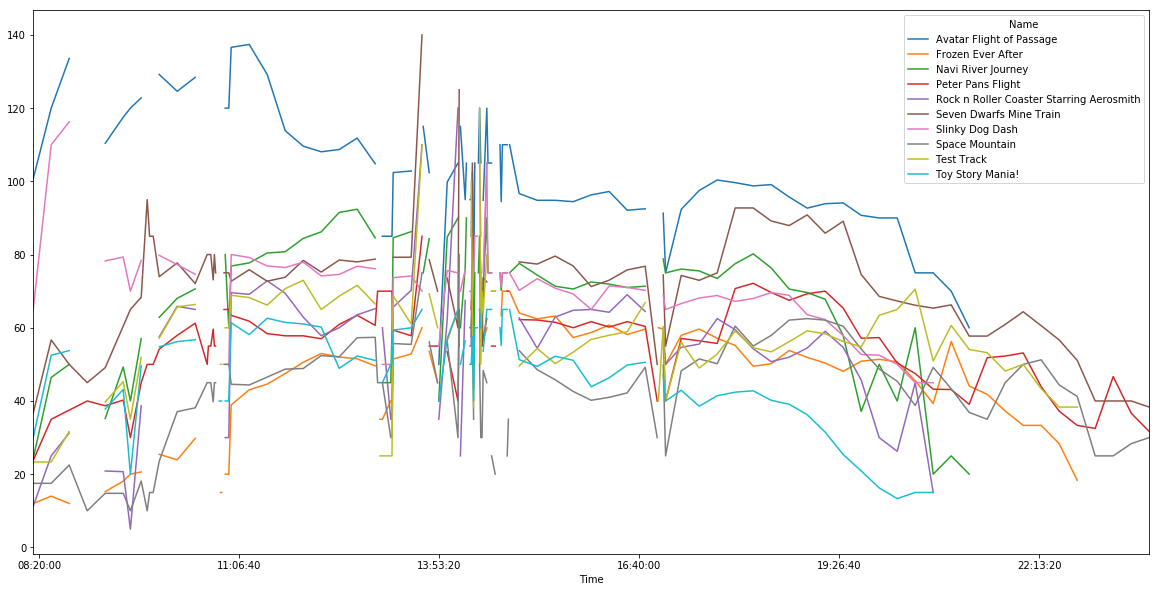

In [46]:
fig,ax = plt.subplots(figsize = (20,10))
topRides.groupby(["Time","Name"])['Wait'].mean().unstack().plot(ax = ax)
plt.show()

The first thing that sticks out in this graph is the solid line that represents the character experience of Cinderella and other Princesses. Perhaps there should a feature that incorporates whether the experience is a character experience or not. Or, more generally, to what branch of IP (intellectual property) does this experience belong? This would help answer the question if rides associated with Princesses tend to have longer waits than rides that do not have a specific associated property image, like Jungle Cruise or the Haunted Mansion.  

## Weather

Up until this point we have analyzed rides without a consideration towards the weather at the time. Orlando has common surprise thunderstorms that may drop wait times as people rush indoors, or it may suddenly increase wait times towards dark rides to avoid the outside. These are things we can look at in principal, then later when they are incorporated into a machine learning model.

In [ ]:
RideWaits["Status"].value_counts()

In [ ]:
RideWaits.groupby('Status')["Wait"].describe()

Initially we have had no conditions with rain, so we can't analyze if rain is or is not having an effect. We see, though that fog does have some effect, however fog mainly only occurs in the morning so that may be more a time constraint than directly related to fog.

In [ ]:
RideWaits.groupby('SimpleStatus')["Wait"].describe()

We also have a simpler status to be able to group some weather statuses more easily. We see here again that Fog is the only substantial difference, but again is this due to morning hours or the fog.

We should now look at the temperature to see if there is any correlation between temperature and wait times. 

In [ ]:
RideWaits.plot(x = "Temperature", y = "Wait", kind = "scatter")

In [ ]:
RideWaits.corr()["Wait"]["Temperature"]

In [ ]:
fig,ax= plt.subplots(figsize = (20,10))
RideWaits.groupby('Temperature')['Wait'].mean().plot(ax = ax)
plt.show()

We see almost the reverse effect we would expect to see with Temperature. I would anticipate that heat would cause people to leave the parks, but, since heat occurs in the middle of the day when the parks are most busy we see that this is presenting itself as a positive correlation, albeit not a strong one, between wait time and temperature. This again leads me to want to capture if a ride is outdoors or a dark ride, as well as whether the queue is outdoors or indoors. 

These all lead to an understanding that Time of Day may be the most important factor in generalizing a wait time, in addition to the specific ride.

It may be easier to view Temperature as a daily high and the average wait time that day, as we can isolate temperature from the time of day considerations and pair all other aspects, such as day of week. This way the comparison will be more apples to apples and we can remove for potentially confounding variables. 

## Intellectual Property

Disney owns a vast array of different Intellectual property that certain rides take advantage of. This is seen with the upcoming additions of Star Wars Land and Toy Story Land. The thought is that certain IP create very popular rides and will increase wait times. 

In [47]:
RideWaits.groupby('IntellectualProp')["Wait"].describe()

,count,mean,std,min,25%,50%,75%,max
IntellectualProp,,,,,,,,
Animated,4889.0,28.585600,22.095123,0.0,10.0,20.0,45.0,120.0
Avatar,2320.0,88.678879,36.153605,5.0,65.0,80.0,105.0,305.0
Fab5,9039.0,22.586569,15.226860,0.0,10.0,20.0,30.0,120.0
Muppets,1168.0,10.706336,2.737012,5.0,10.0,10.0,10.0,25.0
None,27491.0,29.251282,22.181098,0.0,15.0,25.0,40.0,290.0
Pirates,1210.0,25.140496,15.960459,0.0,10.0,25.0,35.0,90.0
Pixar,10773.0,28.693957,22.687564,0.0,10.0,20.0,40.0,190.0
Pooh,1165.0,29.141631,10.846541,5.0,20.0,30.0,35.0,65.0
Princess,12299.0,31.479795,23.225208,0.0,15.0,25.0,45.0,185.0


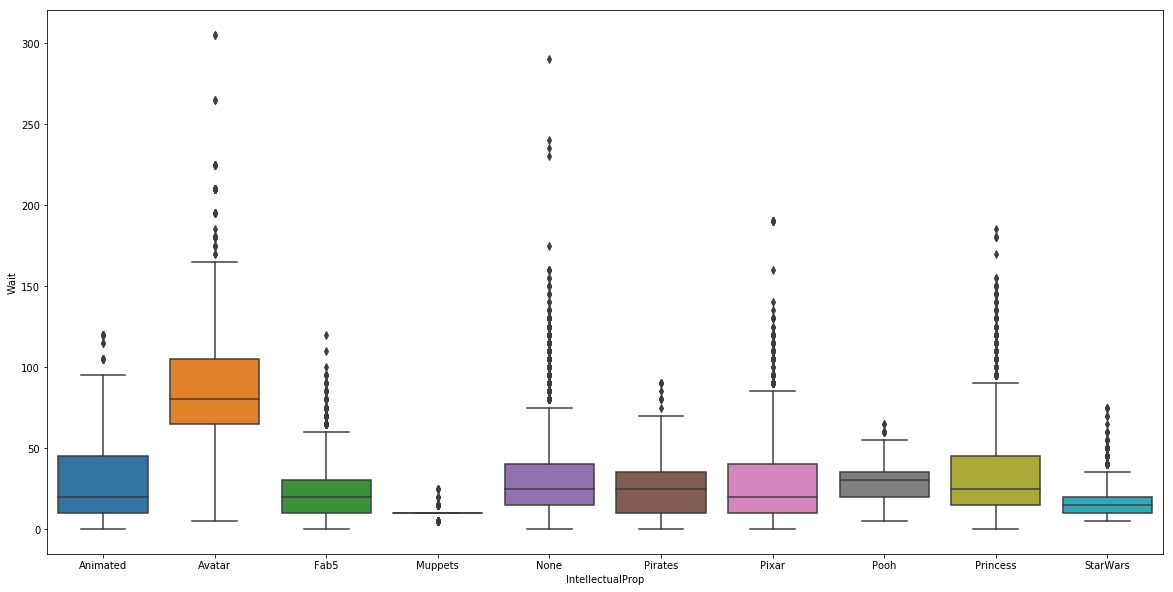

In [48]:
plt.subplots(figsize = (20,10))
ax = sns.boxplot(x = "IntellectualProp", y = "Wait", data = RideWaits)
plt.show()

This doesn't tell much of a story. It's hard to tell if the Intellectual property is causing Avatar to have such high wait times, or is it the tier of the ride, or is it the newness of those rides. All of these factors may be playing a part in the high wait times associated with Avatar related properties. 

### Character Experiences

Character experiences are another type of experience that may effect wait times. Most are devoted to showing off Disney's favorite characters and because of this the wait times for these attractions will tend to soar. 

In [49]:
RideWaits.groupby('CharacterExperience')["Wait"].describe()

,count,mean,std,min,25%,50%,75%,max
CharacterExperience,,,,,,,,
0,61026.0,30.149068,25.733537,0.0,10.0,20.0,40.0,305.0
1,14013.0,26.256333,15.157978,0.0,15.0,25.0,35.0,120.0


In [50]:
RideWaits[RideWaits["CharacterExperience"] == 1]["Name"].unique()

array(['Meet Disney Pals at the Epcot Character Spot',
       'Meet Anna and Elsa at Royal Sommerhus',
       'Meet Daring Disney Pals as Circus Stars at Petes Silly Sideshow',
       'Meet Magnifique Disney Friends as Circus Stars at Petes Silly Sideshow',
       'Meet Mickey Mouse at Town Square Theater',
       'Meet Ariel at Her Grotto',
       'Meet Rapunzel and Tiana at Princess Fairytale Hall',
       'Meet Tinker Bell at Town Square Theater',
       'Meet Cinderella and Elena at Princess Fairytale Hall',
       'Meet Chewbacca at Star Wars Launch Bay',
       'Star Wars Launch Bay: Encounter Kylo Ren',
       'Meet Favorite Disney Pals at Adventurers Outpost'], dtype=object)

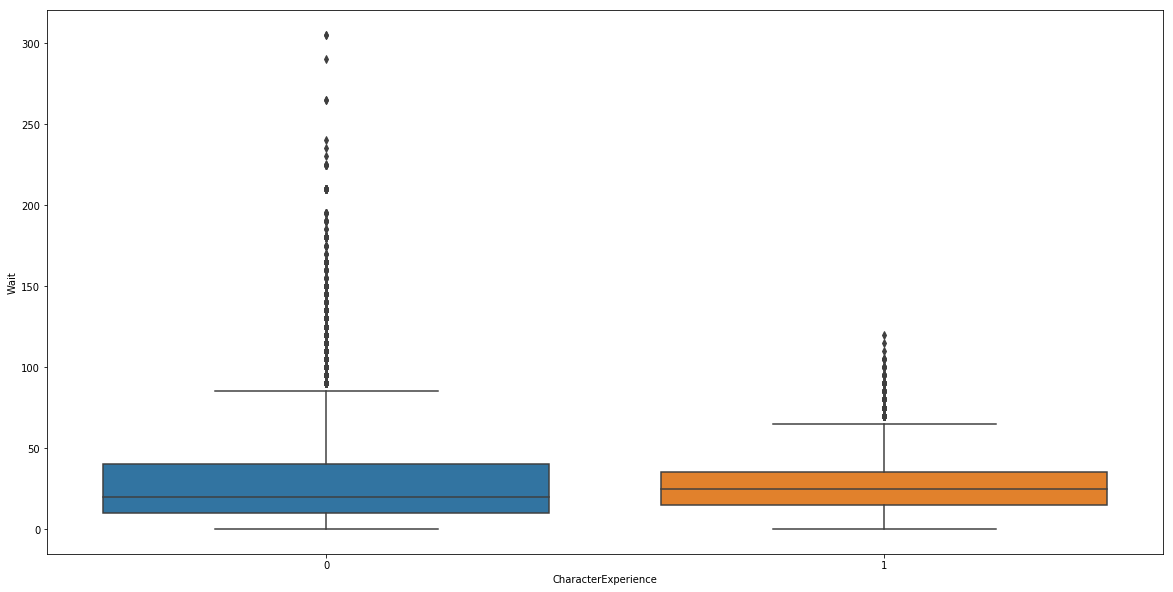

In [51]:
plt.subplots(figsize = (20,10))
ax = sns.boxplot(x = "CharacterExperience", y = "Wait", data = RideWaits)
plt.show()

In [52]:
t, p = stats.ttest_ind(RideWaits[RideWaits["CharacterExperience"] == 0]["Wait"], RideWaits[RideWaits["CharacterExperience"]==1]["Wait"])
print(t)
print(p)

17.233511783472494
1.9991803163579957e-66


Again there is statistical Significance to suggest that a non character experience has a longer wait time than a character experience, leading us to believe that this would be an important aspect to include in a model.

## Looking at the cyclical nature of one ride

We can get some good nature of the cyclical nature of wait times by looking at just a few rides to see how they operate cyclically. I'm going to choose 1 older standard roller coaster, a new roller coaster, and one character experience to see how they manage cyclically.

In [70]:
big_thunder = RideWaits[RideWaits['Name'] == "Big Thunder Mountain Railroad"]

In [71]:
#let's look at a specific two week period to see if there is a weekly eb and flow and an hourly ebb and flow.

In [121]:
big_thunder_recent = big_thunder.tail(400)

In [122]:
big_thunder_recent

,RideId,Date,Time,Wait,Name,OpeningDate,Tier,Location,IntellectualProp,ParkId,...,CharacterExperience,inEMH,validTime,EMHDay,TimeSinceOpen,TimeSinceMidday,MagicHourType,MinutesSinceOpen,Month,TimeSinceRideOpen
52384,80010110,2018-10-04,17:30:00,15,Big Thunder Mountain Railroad,1980-09-23,headliner,Frontierland,None,7,...,0,0,1,0,8,3,None,510.0,10,13890
52411,80010110,2018-10-04,17:45:00,15,Big Thunder Mountain Railroad,1980-09-23,headliner,Frontierland,None,7,...,0,0,1,0,8,3,None,525.0,10,13890
54384,80010110,2018-10-05,09:15:00,15,Big Thunder Mountain Railroad,1980-09-23,headliner,Frontierland,None,7,...,0,0,1,1,0,5,Morning,15.0,10,13891
54411,80010110,2018-10-05,09:30:00,15,Big Thunder Mountain Railroad,1980-09-23,headliner,Frontierland,None,7,...,0,0,1,1,0,5,Morning,30.0,10,13891
54438,80010110,2018-10-05,09:45:00,25,Big Thunder Mountain Railroad,1980-09-23,headliner,Frontierland,None,7,...,0,0,1,1,0,5,Morning,45.0,10,13891
54465,80010110,2018-10-05,10:00:00,35,Big Thunder Mountain Railroad,1980-09-23,headliner,Frontierland,None,7,...,0,0,1,1,1,4,Morning,60.0,10,13891
54493,80010110,2018-10-05,10:15:00,35,Big Thunder Mountain Railroad,1980-09-23,headliner,Frontierland,None,7,...,0,0,1,1,1,4,Morning,75.0,10,13891
54521,80010110,2018-10-05,10:30:00,25,Big Thunder Mountain Railroad,1980-09-23,headliner,Frontierland,None,7,...,0,0,1,1,1,4,Morning,90.0,10,13891
54549,80010110,2018-10-05,10:45:00,35,Big Thunder Mountain Railroad,1980-09-23,headliner,Frontierland,None,7,...,0,0,1,1,1,4,Morning,105.0,10,13891
54577,80010110,2018-10-05,11:00:00,35,Big Thunder Mountain Railroad,1980-09-23,headliner,Frontierland,None,7,...,0,0,1,1,2,3,Morning,120.0,10,13891


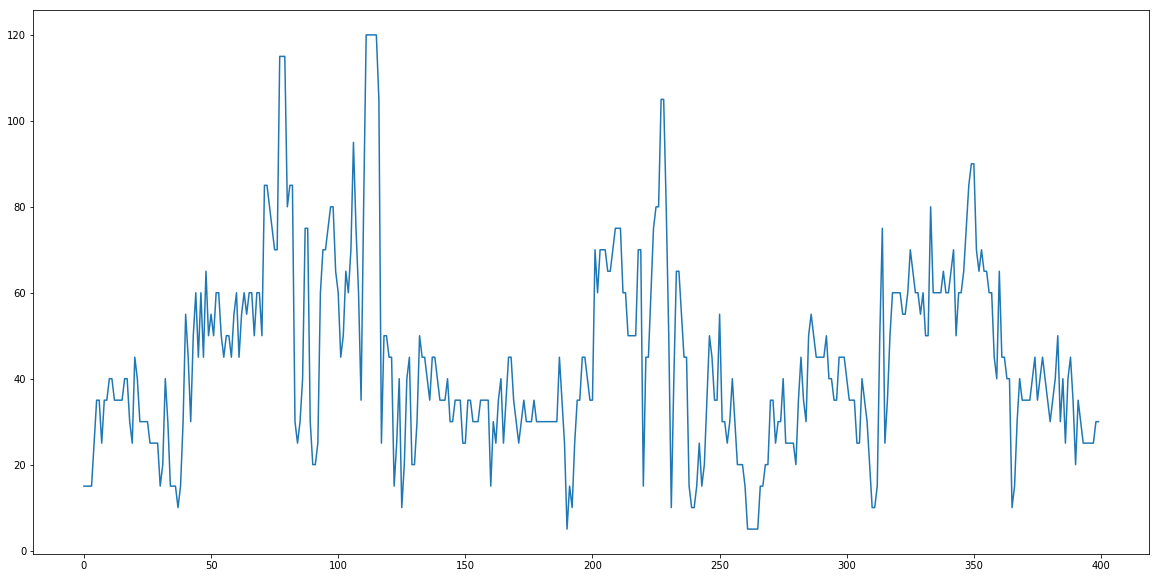

In [123]:
plt.subplots(figsize = (20,10))
big_thunder_recent = big_thunder_recent.reset_index()
plt.plot(big_thunder_recent['Wait'])

In [89]:
#there is a cyclical pattern to these rides that can be tracked every day. There also exists a larger cyclical weekly pattern


In [90]:
slinky_dog = RideWaits[RideWaits['Name'] == "Slinky Dog Dash"]

In [91]:
slinky_dog

,RideId,Date,Time,Wait,Name,OpeningDate,Tier,Location,IntellectualProp,ParkId,...,CharacterExperience,inEMH,validTime,EMHDay,TimeSinceOpen,TimeSinceMidday,MagicHourType,MinutesSinceOpen,Month,TimeSinceRideOpen
2813,18904138,2018-09-19,09:36:00,70,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,0,5,None,36.0,9,81
2821,18904138,2018-09-19,10:52:00,45,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,1,4,None,112.0,9,81
2833,18904138,2018-09-19,10:55:00,50,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,1,4,None,115.0,9,81
2845,18904138,2018-09-19,10:58:00,50,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,1,4,None,118.0,9,81
2890,18904138,2018-09-19,13:04:00,50,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,4,1,None,244.0,9,81
2902,18904138,2018-09-19,13:06:00,50,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,4,1,None,246.0,9,81
2914,18904138,2018-09-19,13:13:00,50,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,4,1,None,253.0,9,81
2925,18904138,2018-09-19,13:14:00,50,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,4,1,None,254.0,9,81
2943,18904138,2018-09-19,13:53:00,55,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,4,1,None,293.0,9,81
2955,18904138,2018-09-19,14:15:00,60,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,5,0,None,315.0,9,81


In [95]:
slinky_dog_recent = slinky_dog.tail(200)

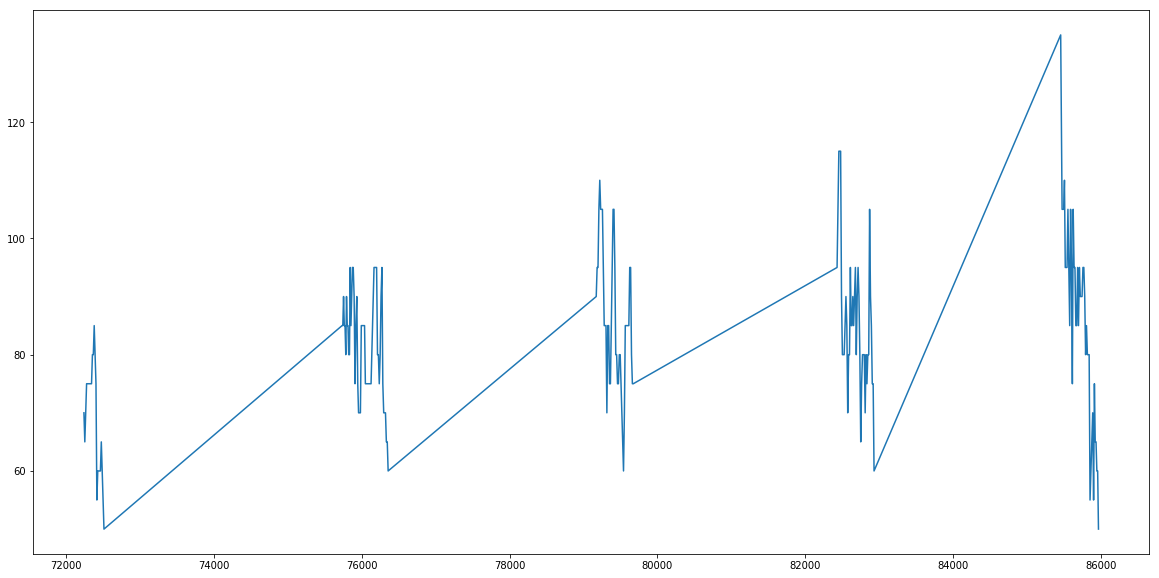

In [96]:
plt.subplots(figsize = (20,10))

plt.plot(slinky_dog_recent['Wait'])

In [116]:
slinky_one_day = slinky_dog[slinky_dog['Date'].isin(["2018-10-12","2018-10-13","2018-10-14"])]


In [117]:
slinky_one_day

,RideId,Date,Time,Wait,Name,OpeningDate,Tier,Location,IntellectualProp,ParkId,...,CharacterExperience,inEMH,validTime,EMHDay,TimeSinceOpen,TimeSinceMidday,MagicHourType,MinutesSinceOpen,Month,TimeSinceRideOpen
79172,18904138,2018-10-12,09:15:00,90,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,0,5,None,15.0,10,104
79184,18904138,2018-10-12,09:30:00,95,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,0,5,None,30.0,10,104
79196,18904138,2018-10-12,09:45:00,95,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,0,5,None,45.0,10,104
79208,18904138,2018-10-12,10:00:00,105,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,1,4,None,60.0,10,104
79220,18904138,2018-10-12,10:15:00,110,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,1,4,None,75.0,10,104
79232,18904138,2018-10-12,10:30:00,105,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,1,4,None,90.0,10,104
79244,18904138,2018-10-12,10:45:00,105,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,1,4,None,105.0,10,104
79256,18904138,2018-10-12,11:00:00,105,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,2,3,None,120.0,10,104
79268,18904138,2018-10-12,11:15:00,95,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,2,3,None,135.0,10,104
79280,18904138,2018-10-12,11:30:00,85,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,8,...,0,0,1,0,2,3,None,150.0,10,104


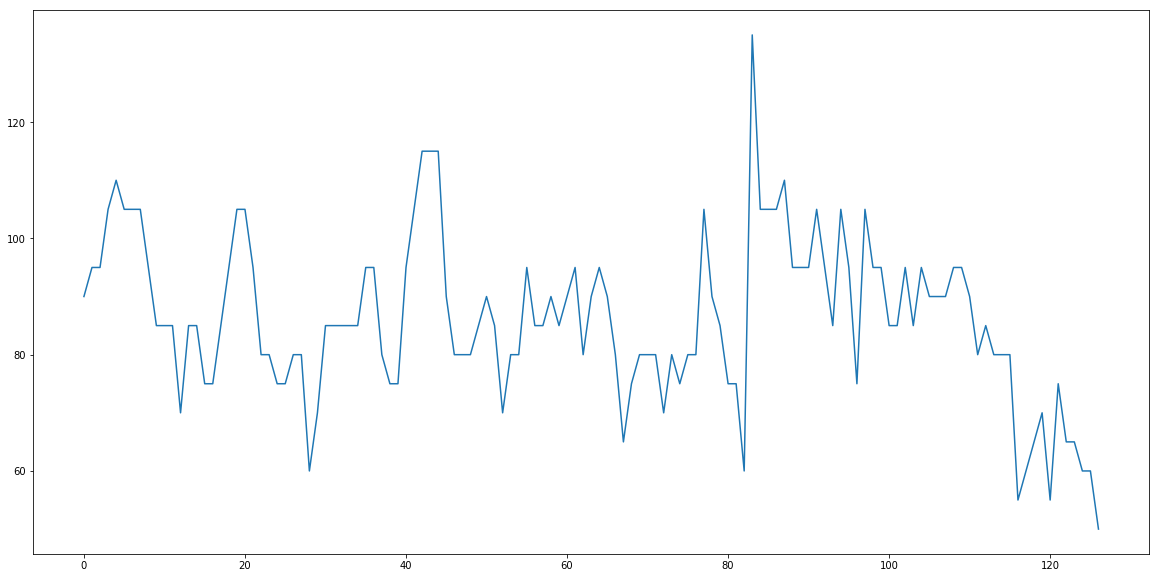

In [118]:
plt.subplots(figsize = (20,10))

slinky_one_day = slinky_one_day.reset_index()

plt.plot(slinky_one_day['Wait'])

In [109]:
slinky_one_day=slinky_one_day.reset_index()

In [119]:
slinky_one_day

,index,RideId,Date,Time,Wait,Name,OpeningDate,Tier,Location,IntellectualProp,...,CharacterExperience,inEMH,validTime,EMHDay,TimeSinceOpen,TimeSinceMidday,MagicHourType,MinutesSinceOpen,Month,TimeSinceRideOpen
0,79172,18904138,2018-10-12,09:15:00,90,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,...,0,0,1,0,0,5,None,15.0,10,104
1,79184,18904138,2018-10-12,09:30:00,95,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,...,0,0,1,0,0,5,None,30.0,10,104
2,79196,18904138,2018-10-12,09:45:00,95,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,...,0,0,1,0,0,5,None,45.0,10,104
3,79208,18904138,2018-10-12,10:00:00,105,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,...,0,0,1,0,1,4,None,60.0,10,104
4,79220,18904138,2018-10-12,10:15:00,110,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,...,0,0,1,0,1,4,None,75.0,10,104
5,79232,18904138,2018-10-12,10:30:00,105,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,...,0,0,1,0,1,4,None,90.0,10,104
6,79244,18904138,2018-10-12,10:45:00,105,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,...,0,0,1,0,1,4,None,105.0,10,104
7,79256,18904138,2018-10-12,11:00:00,105,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,...,0,0,1,0,2,3,None,120.0,10,104
8,79268,18904138,2018-10-12,11:15:00,95,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,...,0,0,1,0,2,3,None,135.0,10,104
9,79280,18904138,2018-10-12,11:30:00,85,Slinky Dog Dash,2018-06-30,major_attraction,Toy Story Land,Pixar,...,0,0,1,0,2,3,None,150.0,10,104


In [124]:
#we see some predictable cyclical nature of each daily period. This will help us make predictions on wait times in the future.
#further this means we can use past times to predict forward times, and implement a shift. So the time at 2pm is influenced by
#the time at 1pm